# Import Libraries

In [ ]:
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

In [ ]:
%load_ext tensorboard

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff



SEED = 0
tf.random.set_seed(SEED)
np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
tff.__version__

'0.20.0'

In [ ]:
!python --version

Python 3.7.13


In [ ]:
from tensorflow import keras
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from keras import layers
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import time


# Load data

In [ ]:
path = "/content/drive/MyDrive/Thesis/Datasets/Pasteurizer_dataset/"

In [ ]:
alice_df = pd.read_csv(path+ "federated/alice_set.csv")
bob_df = pd.read_csv(path+ "federated/bob_set.csv")

test_df = pd.read_csv(path+ "federated/test_set.csv")

In [ ]:
feature_cols = ['paster_timeslot', 'prev_water_temp', 'curr_water_temp', 'bath_number', 'curr_bath_temp']

In [ ]:
alice_df

,paster_id,paster_timeslot,prev_water_temp,prev_can_temp,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,47,20,33.47,30.26,37.40,1,44.0188,30.47
1,47,30,37.40,30.47,38.69,1,43.9500,30.61
2,47,40,38.69,30.61,38.31,1,43.8500,30.85
3,47,50,38.31,30.85,37.73,1,43.7625,31.02
4,47,60,37.73,31.02,37.61,1,43.6813,31.27
...,...,...,...,...,...,...,...,...
23573,99,1830,36.03,38.43,36.32,6,35.2188,38.21
23574,99,1840,36.32,38.21,36.43,6,35.2438,38.04
23575,99,1850,36.43,38.04,36.43,6,35.1750,37.90
23576,99,1860,36.43,37.90,36.44,6,35.2313,37.78


In [ ]:
bob_df

,paster_id,paster_timeslot,prev_water_temp,prev_can_temp,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,39,20,32.22,28.68,34.68,1,39.2062,28.70
1,39,30,34.68,28.70,35.78,1,39.0688,28.74
2,39,40,35.78,28.74,36.01,1,38.9875,28.80
3,39,50,36.01,28.80,36.60,1,38.8812,28.84
4,39,60,36.60,28.84,37.04,1,38.7687,28.92
...,...,...,...,...,...,...,...,...
23389,65,1790,36.80,38.80,36.96,6,35.9438,38.67
23390,65,1800,36.96,38.67,36.98,6,36.0000,38.53
23391,65,1810,36.98,38.53,36.97,6,36.0125,38.43
23392,65,1820,36.97,38.43,36.94,6,36.0812,38.36


In [ ]:
test_df

,paster_id,paster_timeslot,prev_water_temp,prev_can_temp,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,214,20,36.25,28.00,38.71,1,44.0938,28.10
1,214,30,38.71,28.10,39.73,1,44.0000,28.27
2,214,40,39.73,28.27,40.57,1,43.9062,28.54
3,214,50,40.57,28.54,40.78,1,43.8187,28.80
4,214,60,40.78,28.80,41.36,1,43.7750,29.20
...,...,...,...,...,...,...,...,...
12173,149,2180,38.89,43.86,38.69,6,33.9562,43.46
12174,149,2190,38.69,43.46,38.64,6,33.9938,43.08
12175,149,2200,38.64,43.08,38.55,6,34.0563,42.69
12176,149,2210,38.55,42.69,38.31,6,34.1250,42.41


# Preparing Data

In [ ]:
# min max normalization

alice_df[feature_cols]=(alice_df[feature_cols]-alice_df[feature_cols].mean())/alice_df[feature_cols].std()
bob_df[feature_cols]=(bob_df[feature_cols]-bob_df[feature_cols].mean())/bob_df[feature_cols].std()



test_df[feature_cols]=(test_df[feature_cols]-test_df[feature_cols].mean())/test_df[feature_cols].std()

# Sequence Creation

In [ ]:
# Receives single engine dataframe, window size and features -> sequences of length==window_size
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [ ]:
# Generates sequences for multiple engines
def gen_data_wrapper(df, sequence_length, columns, ids=np.array([])):
    if ids.size <= 0:
        ids = df['paster_id'].unique()
        
    data_gen = (list(gen_train_data(df[df['paster_id']==id], sequence_length, columns))
               for id in ids)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [ ]:
# Functions to generate sequences for the labals
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, ids=np.array([])):
    if ids.size <= 0:
        ids = df['paster_id'].unique()
        
    label_gen = [gen_labels(df[df['paster_id']==id], sequence_length, label) 
                for id in ids]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [ ]:
sequence_length = 20

gss = GroupShuffleSplit(n_splits=1, train_size=0.95, random_state=42)


# for train_unit, val_unit in gss.split(train_df['paster_id'].unique(), groups=train_df['paster_id'].unique()):
#     train_unit = train_df['paster_id'].unique()[train_unit]  # gss returns indexes and index starts at 1
#     val_unit = train_df['paster_id'].unique()[val_unit]

#     train_split_array = gen_data_wrapper(train_df, sequence_length, feature_cols, train_unit)
#     train_split_label = gen_label_wrapper(train_df, sequence_length, ['curr_can_temp'], train_unit)
    
#     val_split_array = gen_data_wrapper(train_df, sequence_length, feature_cols, val_unit)
#     val_split_label = gen_label_wrapper(train_df, sequence_length, ['curr_can_temp'], val_unit)

# create sequences train, test 
X_alice = gen_data_wrapper(alice_df, sequence_length, feature_cols)
y_alice = gen_label_wrapper(alice_df, sequence_length, ['curr_can_temp'])

X_bob = gen_data_wrapper(bob_df, sequence_length, feature_cols)
y_bob = gen_label_wrapper(bob_df, sequence_length, ['curr_can_temp'])

X_test = gen_data_wrapper(test_df, sequence_length, feature_cols)
y_test = gen_label_wrapper(test_df, sequence_length, ['curr_can_temp'])

# Hyperparameters

In [ ]:
# BATCH_SIZE = 16
BATCH_SIZE = 32
GLOBAL_EPOCHS = 5
LOCAL_EPOCHS = 5


# Federated Dataset

In [ ]:
# y_alice = y_alice.astype(np.int32)
# y_bob = y_bob.astype(np.int32)

In [ ]:
X_alice.dtype

dtype('float32')

In [ ]:
X_bob.dtype

dtype('float32')

In [ ]:
train_data, val_data = [], []

temp_dataset = tf.data.Dataset.from_tensor_slices((X_alice, y_alice)).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)
temp_dataset = tf.data.Dataset.from_tensor_slices((X_bob, y_bob)).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)

temp_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_data.append(temp_dataset.batch(1))

In [ ]:
train_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 20, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>]

In [ ]:
val_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>]

# Create Model

In [ ]:
def input_spec():
    return (
        tf.TensorSpec([None, sequence_length, 5], tf.float32),
        tf.TensorSpec([None, 1], tf.float32)
    )

def model_fn(centralized=False):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(sequence_length, 5,)),                                       
        tf.keras.layers.LSTM(32, activation='tanh'),
        tf.keras.layers.Dense(1, activation='relu'),
    ])

    if centralized:
      return model
    else:
      return tff.learning.from_keras_model(
          model,
          input_spec=input_spec(),
          loss=tf.keras.losses.MeanSquaredError(),
          metrics=[MeanAbsoluteError(),RootMeanSquaredError(), MeanSquaredError()])

# Training

In [ ]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate = 0.35)
    # server_optimizer_fn=lambda: tf.keras.optimizers.Adam()

)

In [ ]:
# creating the directory and the corresponding summary writer to write the metrics to

#@test {"skip": true}
# logdir = "/tmp/logs/scalars/training/"
# summary_writer = tf.summary.create_file_writer(logdir)
# state = trainer.initialize()

In [ ]:


state = trainer.initialize()
train_hist = []

start = time.time()
# with summary_writer.as_default():
for round_num in range(GLOBAL_EPOCHS):
    state, metrics = trainer.next(state, train_data)
      # for name, value in metrics['train'].items():
      #   tf.summary.scalar(name, value, step=round_num)

    train_hist.append(metrics)

    print(f"\rRun {round_num+1}/{GLOBAL_EPOCHS}    ", end="")
    print("RMSE: {rmse}, loss: {loss}".format(rmse = metrics["train"]['root_mean_squared_error'], loss = metrics["train"]['loss']))
end = time.time()
print(f"Training time {end - start:.2f} sec")

Run 1/5    RMSE: 20.3980712890625, loss: 416.0813293457031
Run 2/5    RMSE: 15.696666717529297, loss: 246.38536071777344
Run 3/5    RMSE: 9.564417839050293, loss: 91.47809600830078
Run 4/5    RMSE: 5.436164379119873, loss: 29.551881790161133
Run 5/5    RMSE: 3.8382983207702637, loss: 14.732534408569336
Training time 199.58 sec


In [ ]:
# train_hist

In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:

federated_metrics = evaluator(state.model, train_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('mean_absolute_error', 1.4935212),
                           ('root_mean_squared_error', 1.8361435),
                           ('mean_squared_error', 3.3714228),
                           ('loss', 3.3714228),
                           ('num_examples', 214720),
                           ('num_batches', 6711)]))])

# Evaluation

In [ ]:
centralized_model = model_fn(centralized=True)

In [ ]:
# centralized_model.get_weights()

In [ ]:
# Compile a centralized model with the federated weights

centralized_model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[MeanAbsoluteError(),RootMeanSquaredError(), MeanSquaredError()])
state.model.assign_weights_to(centralized_model)

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mae = mean_absolute_error(y_true, y_hat)
    mse = mean_squared_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat, squared=False)
    variance = r2_score(y_true, y_hat)
    print('{} set: MAE:{} RMSE:{}, MSE:{}, R2:{}'.format(label,mae, rmse, mse, variance))

In [ ]:
X_train_only = np.concatenate((X_alice, X_bob), axis=0)
y_train_only = np.concatenate((y_alice, y_bob), axis=0)

In [ ]:
# X_alice[:alice_split], y_alice[:alice_split]

# y_hat_train = centralized_model.predict(X_alice[:alice_split])
# evaluate(y_alice[:alice_split], y_hat_train)

In [ ]:
# y_hat_train = centralized_model.predict(X_bob[:bob_split])
# evaluate(y_bob[:bob_split], y_hat_train)

In [ ]:
y_hat_train_only = centralized_model.predict(X_train_only)
evaluate(y_train_only, y_hat_train_only, label='train')

train set: MAE:1.4935213327407837 RMSE:1.8361427783966064, MSE:3.37142014503479, R2:0.9356240039045817


In [ ]:
y_hat_test = centralized_model.predict(X_test)
evaluate(y_test, y_hat_test)

test set: MAE:1.586516261100769 RMSE:2.2914650440216064, MSE:5.250812530517578, R2:0.9059826072737303


In [ ]:
y_hat_test

array([[43.68438 ],
       [44.430504],
       [44.865177],
       ...,
       [43.03813 ],
       [41.451107],
       [40.64939 ]], dtype=float32)

In [ ]:
y_test

array([[41.66],
       [42.52],
       [43.26],
       ...,
       [42.69],
       [42.41],
       [42.17]], dtype=float32)

# Temp Plots

In [ ]:
test_df

,paster_id,paster_timeslot,prev_water_temp,prev_can_temp,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,214,-1.668826,-2.034925,28.00,-1.760130,-2.037563,-1.028705,28.10
1,214,-1.651990,-1.751838,28.10,-1.642320,-2.037563,-1.038268,28.27
2,214,-1.635153,-1.634460,28.27,-1.545301,-2.037563,-1.047831,28.54
3,214,-1.618317,-1.537796,28.54,-1.521046,-2.037563,-1.056752,28.80
4,214,-1.601481,-1.513630,28.80,-1.454056,-2.037563,-1.061207,29.20
...,...,...,...,...,...,...,...,...
12173,149,1.967827,-1.731124,43.86,-1.762440,1.565794,-2.062243,43.46
12174,149,1.984663,-1.754139,43.46,-1.768215,1.565794,-2.058410,43.08
12175,149,2.001499,-1.759893,43.08,-1.778610,1.565794,-2.052038,42.69
12176,149,2.018336,-1.770250,42.69,-1.806329,1.565794,-2.045034,42.41


In [ ]:
test_ids = list(pd.unique(test_df.paster_id))
# test_ids


In [ ]:
X_test_list = []
y_test_list = []


for id in test_ids:
  my_df = test_df.loc[ test_df.paster_id == id ]


  # gen_train_data(my_df, sequence_length, feature_cols)

  X_test = list(gen_train_data(my_df, sequence_length, feature_cols))
  y_test = list(my_df['curr_can_temp'])


  X_test_list.append(np.asarray(X_test))
  y_test_list.append(np.asarray(y_test)[sequence_length-1:])

In [ ]:
pred_list = []
for x in X_test_list:
  pred_list.append(centralized_model.predict(x))

In [ ]:
pred_list[0].shape

(179, 1)

In [ ]:
# 7,8,9,10,16,18,33, !!37!!, 38!, 47!

In [ ]:
def my_plot(true, prediction):
  line_thickness = 5
  plt.clf()
  plt.figure(figsize=(8,8))
  plt.plot(range(1, len(true)+1), true, label='true', linewidth=line_thickness, c='g')
  plt.plot(range(1, len(prediction)+1), prediction, label='predicted', linewidth=line_thickness, c='r')


  plt.xlabel('cycles')
  plt.ylabel('temperature(celcius)')
  plt.legend()
  plt.show()


<Figure size 432x288 with 0 Axes>

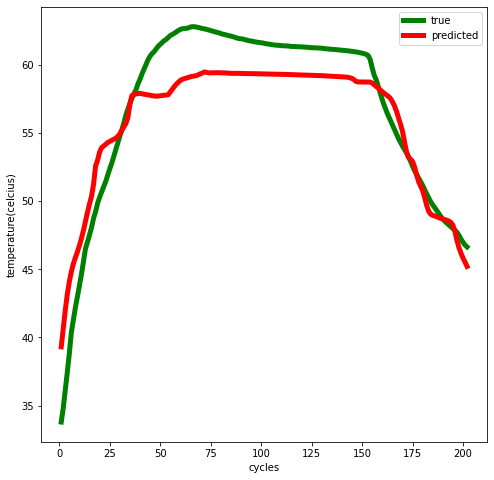

In [ ]:
pos = 37
my_plot(y_test_list[pos] , pred_list[pos])

0


<Figure size 432x288 with 0 Axes>

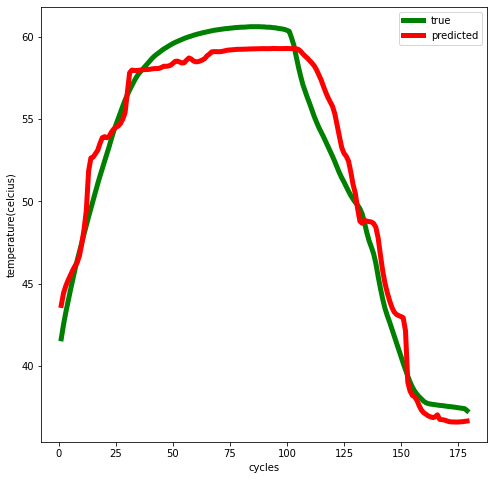

1


<Figure size 432x288 with 0 Axes>

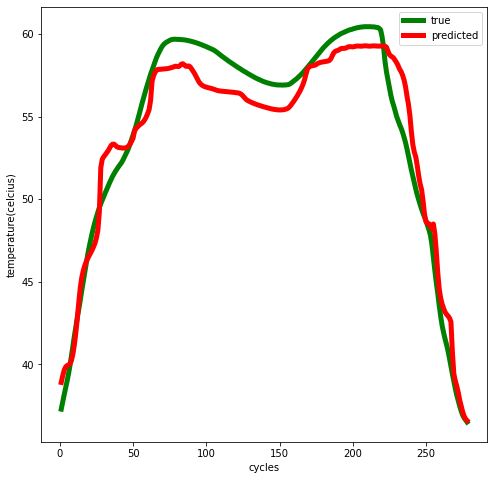

2


<Figure size 432x288 with 0 Axes>

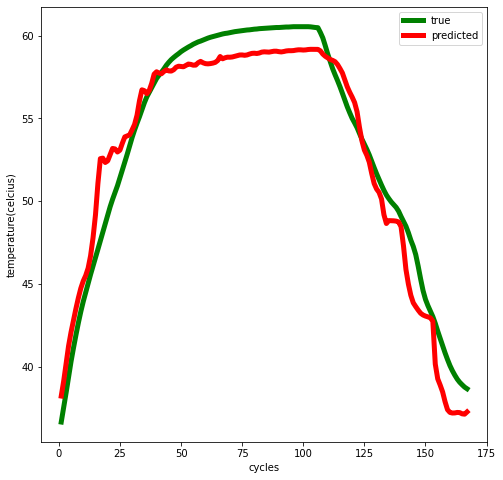

3


<Figure size 432x288 with 0 Axes>

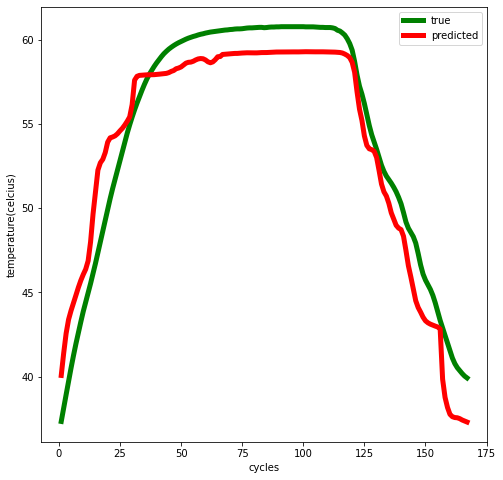

4


<Figure size 432x288 with 0 Axes>

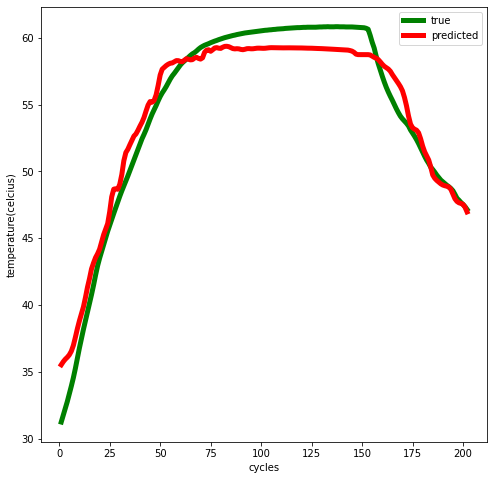

5


<Figure size 432x288 with 0 Axes>

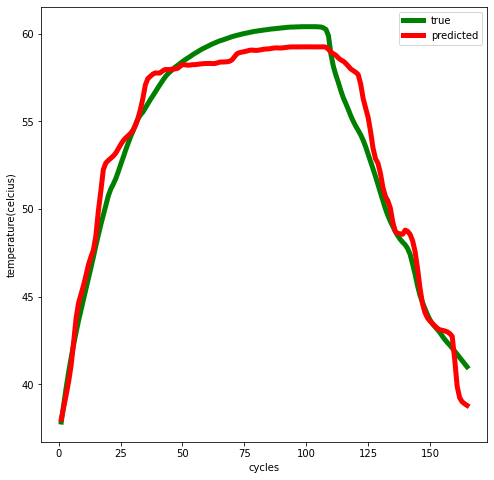

6


<Figure size 432x288 with 0 Axes>

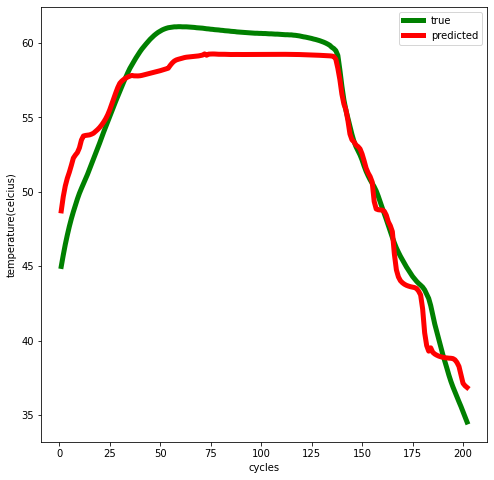

7


<Figure size 432x288 with 0 Axes>

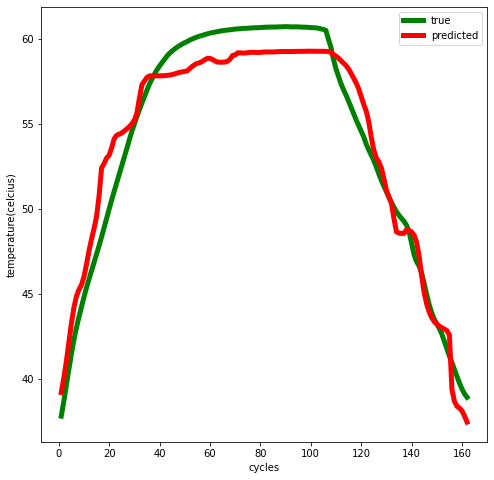

8


<Figure size 432x288 with 0 Axes>

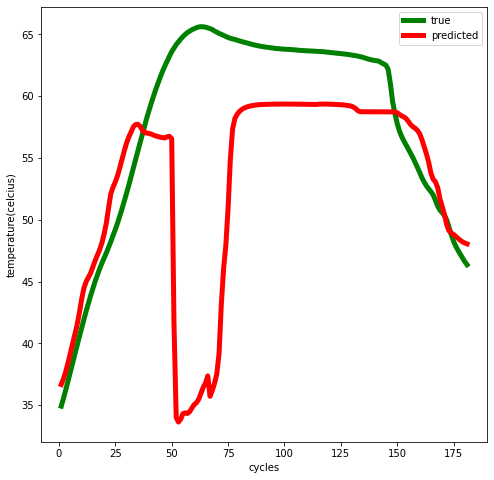

9


<Figure size 432x288 with 0 Axes>

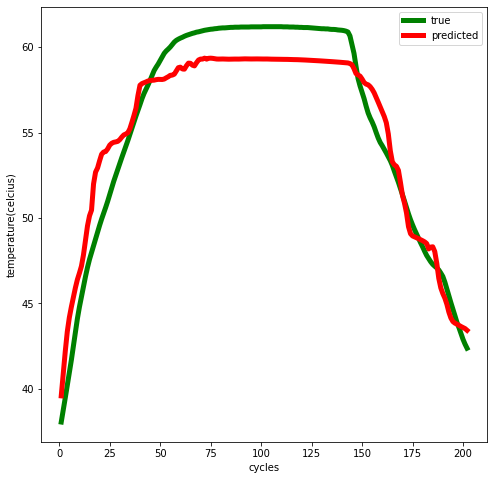

10


<Figure size 432x288 with 0 Axes>

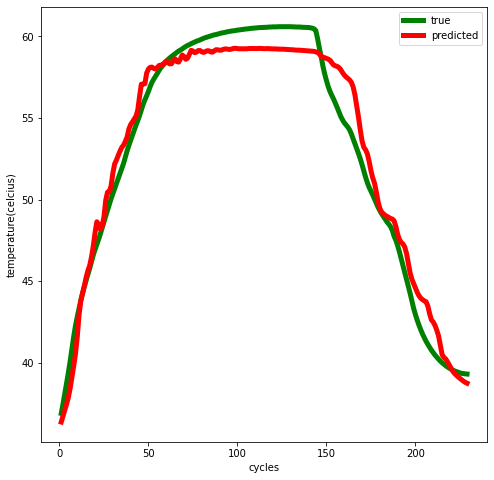

11


<Figure size 432x288 with 0 Axes>

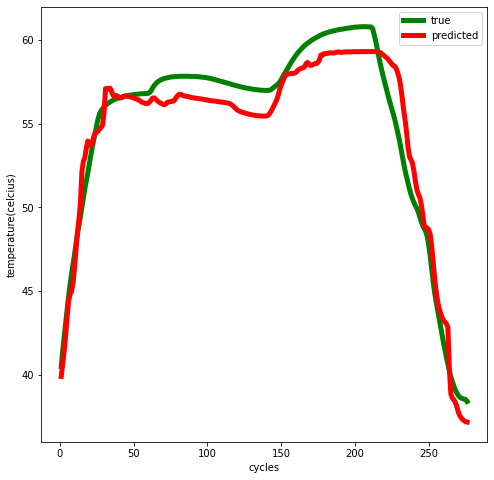

12


<Figure size 432x288 with 0 Axes>

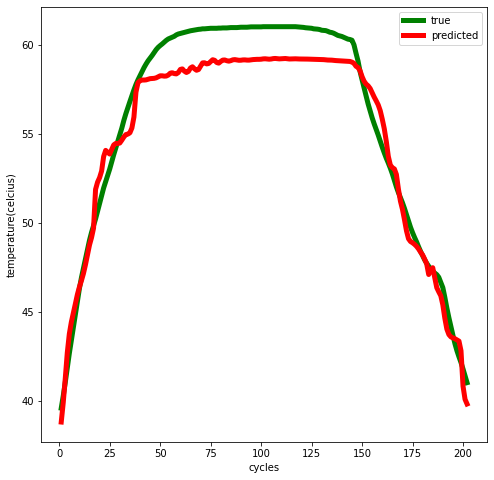

13


<Figure size 432x288 with 0 Axes>

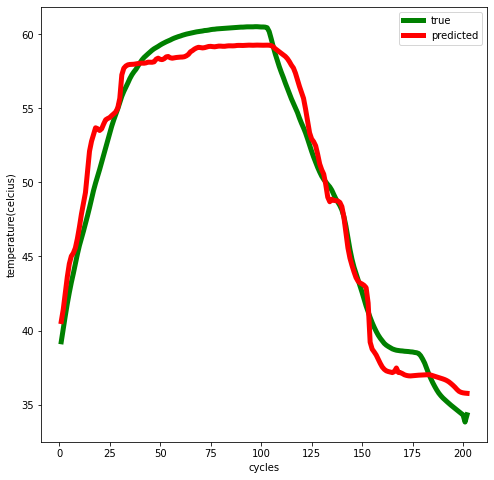

14


<Figure size 432x288 with 0 Axes>

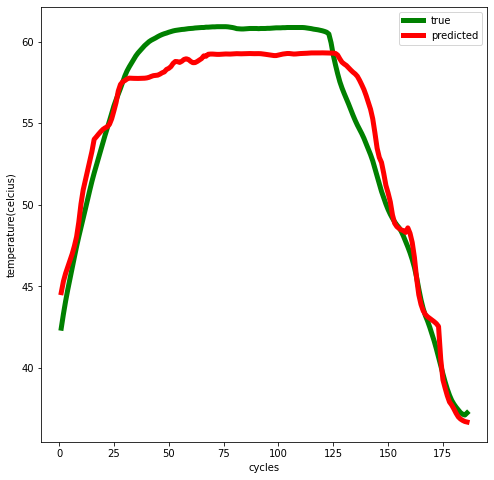

15


<Figure size 432x288 with 0 Axes>

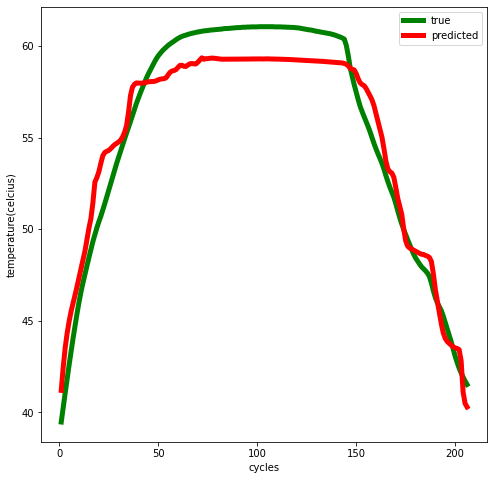

16


<Figure size 432x288 with 0 Axes>

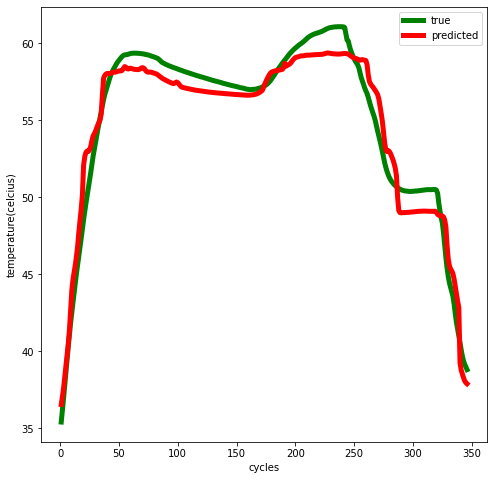

17


<Figure size 432x288 with 0 Axes>

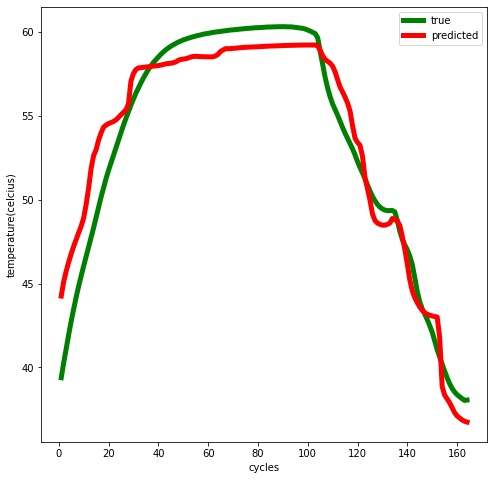

18


<Figure size 432x288 with 0 Axes>

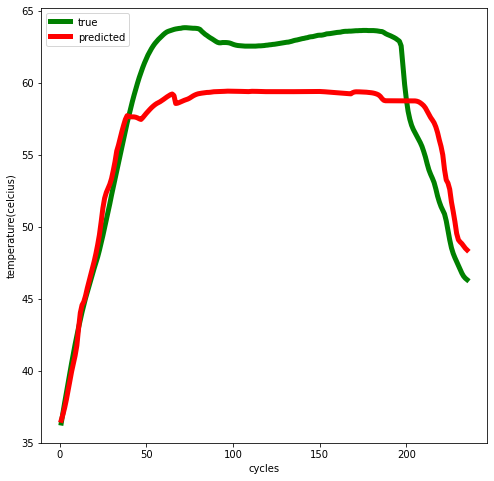

19


<Figure size 432x288 with 0 Axes>

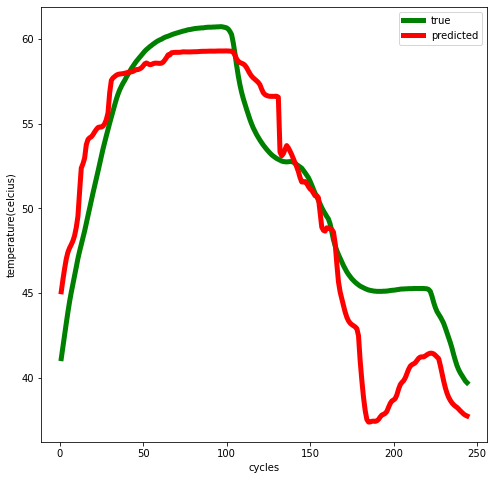

20


<Figure size 432x288 with 0 Axes>

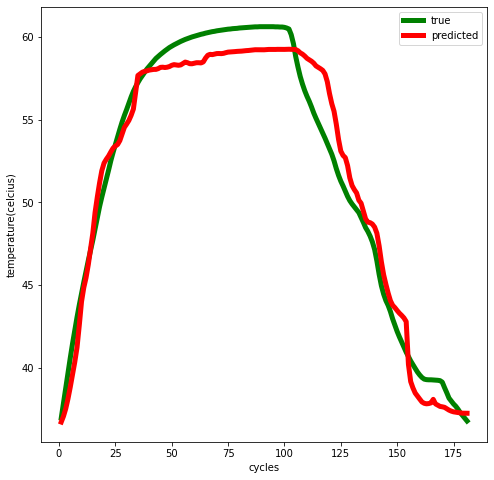

21


<Figure size 432x288 with 0 Axes>

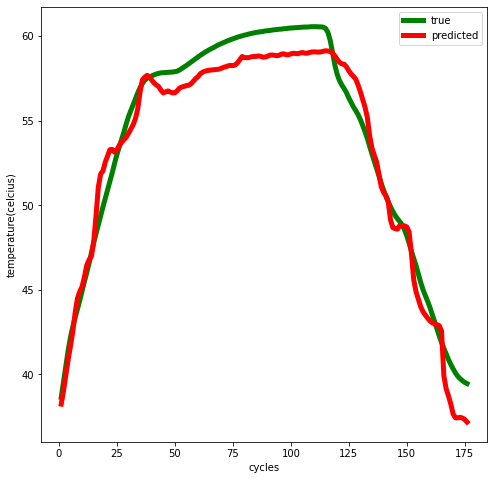

22


<Figure size 432x288 with 0 Axes>

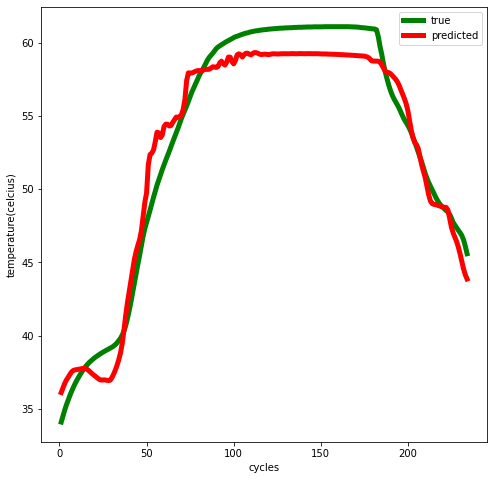

23


<Figure size 432x288 with 0 Axes>

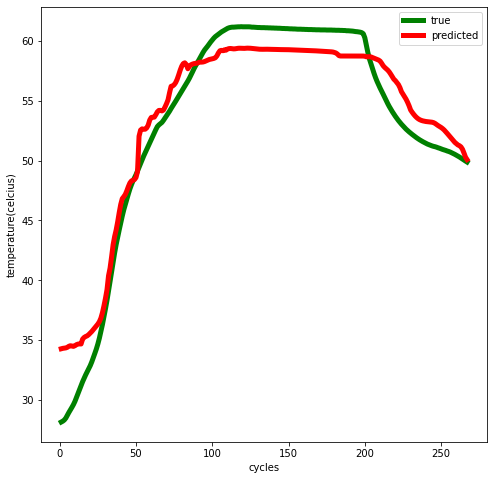

24


<Figure size 432x288 with 0 Axes>

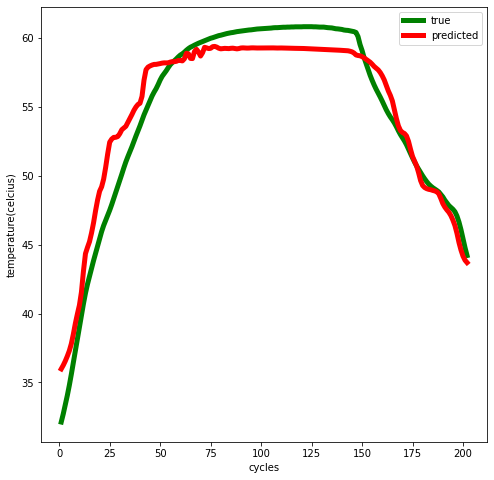

25


<Figure size 432x288 with 0 Axes>

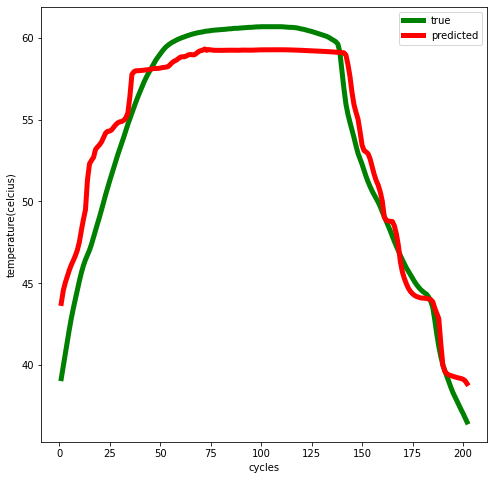

26


<Figure size 432x288 with 0 Axes>

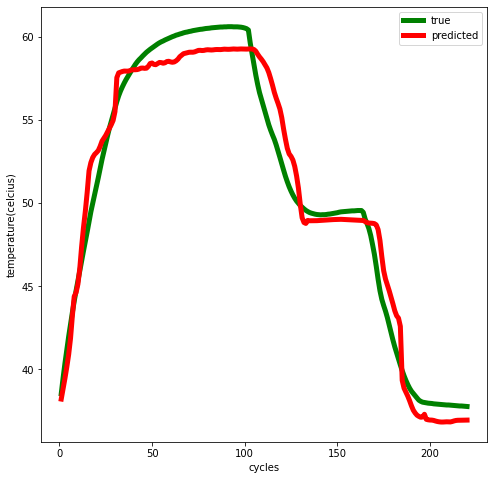

27


<Figure size 432x288 with 0 Axes>

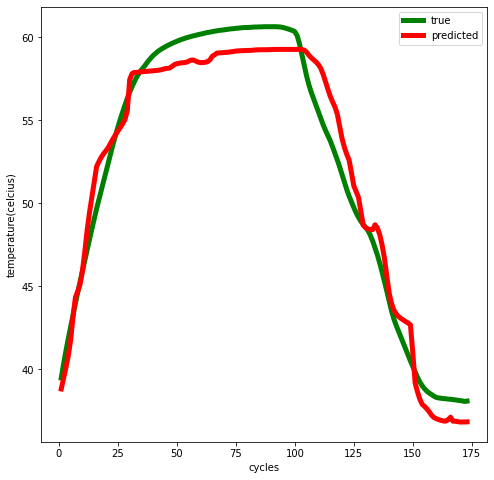

28


<Figure size 432x288 with 0 Axes>

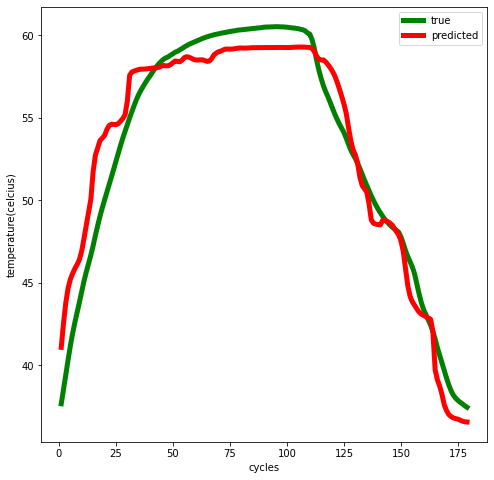

29


<Figure size 432x288 with 0 Axes>

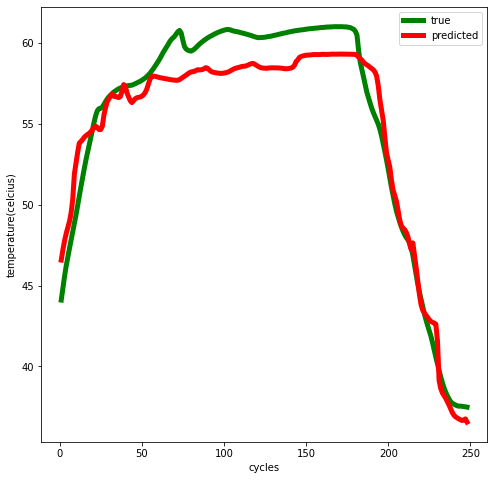

30


<Figure size 432x288 with 0 Axes>

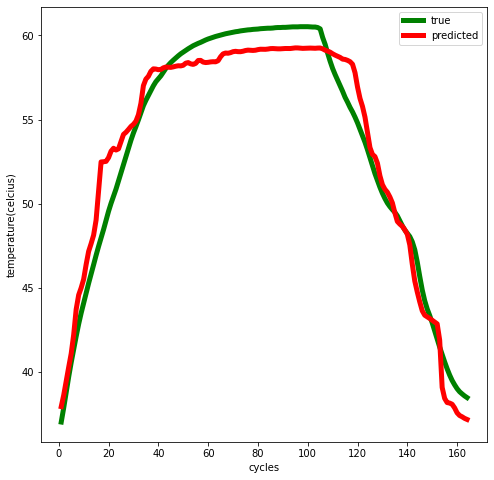

31


<Figure size 432x288 with 0 Axes>

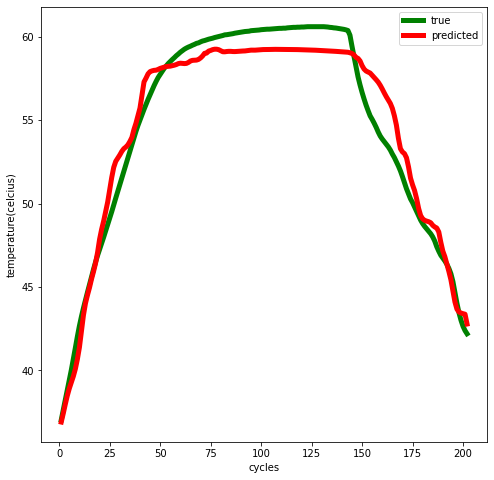

32


<Figure size 432x288 with 0 Axes>

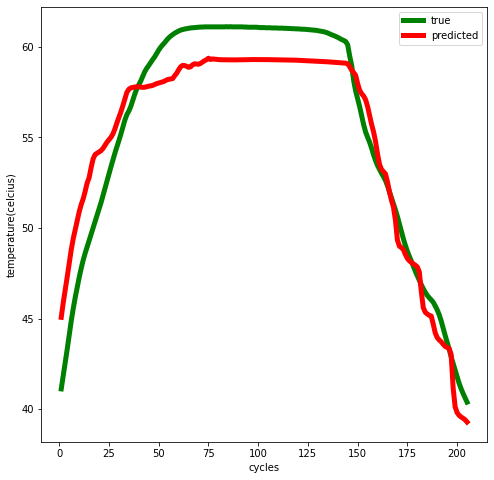

33


<Figure size 432x288 with 0 Axes>

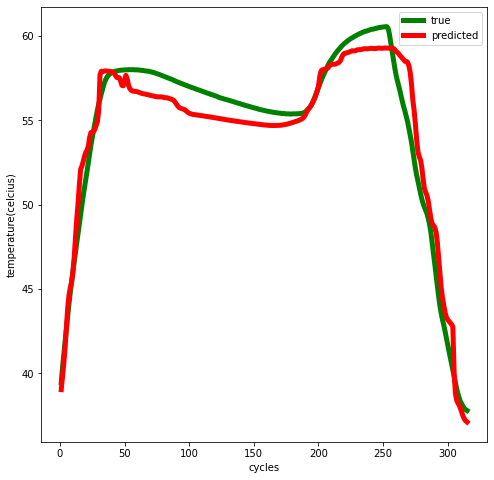

34


<Figure size 432x288 with 0 Axes>

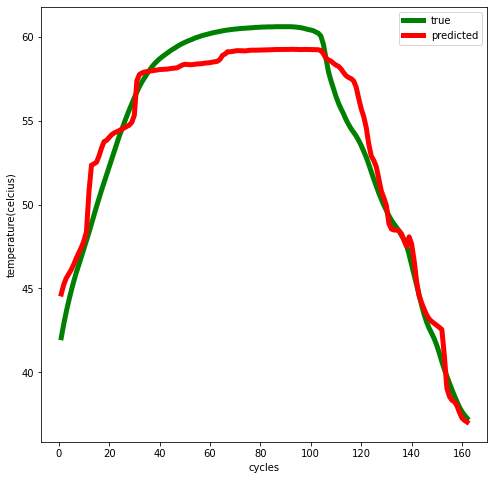

35


<Figure size 432x288 with 0 Axes>

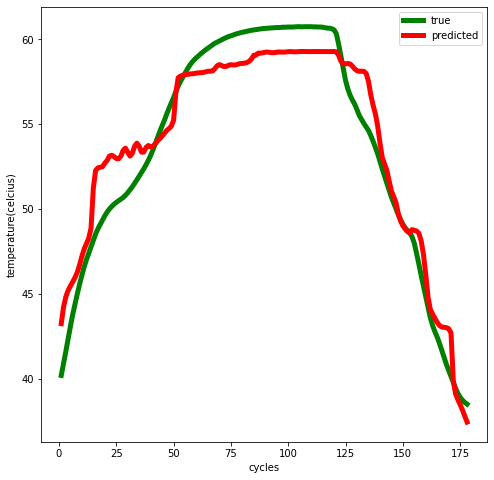

36


<Figure size 432x288 with 0 Axes>

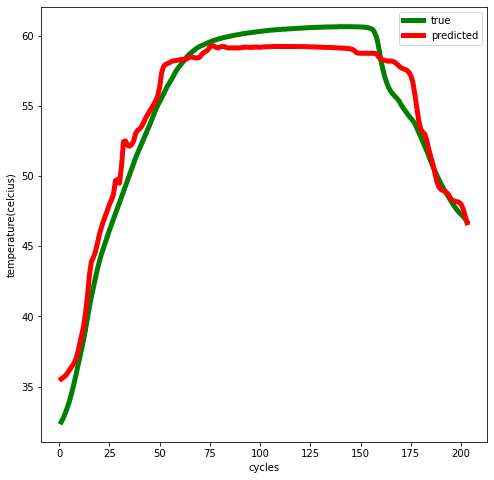

37


<Figure size 432x288 with 0 Axes>

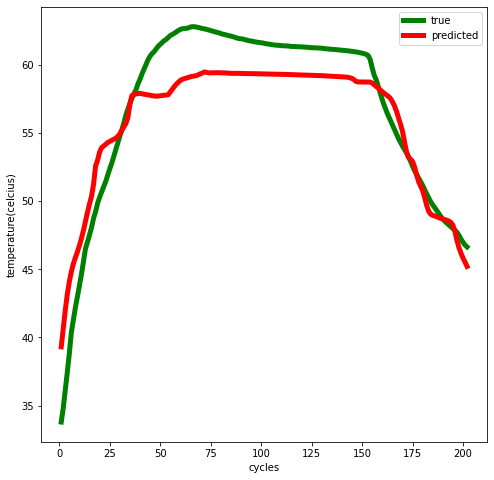

38


<Figure size 432x288 with 0 Axes>

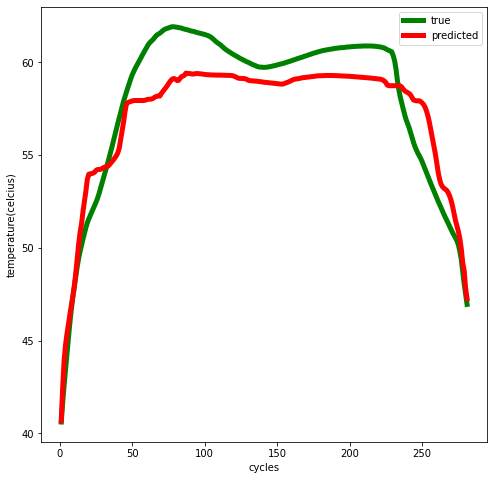

39


<Figure size 432x288 with 0 Axes>

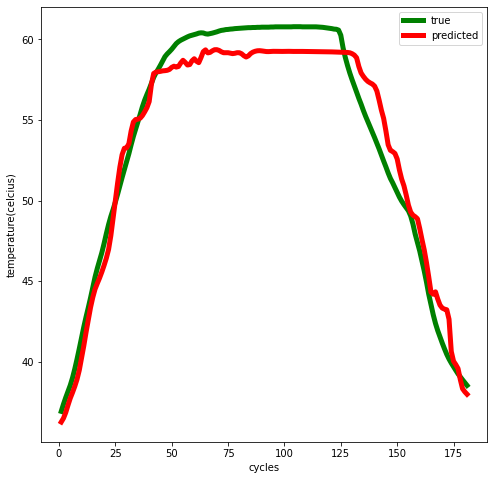

40


<Figure size 432x288 with 0 Axes>

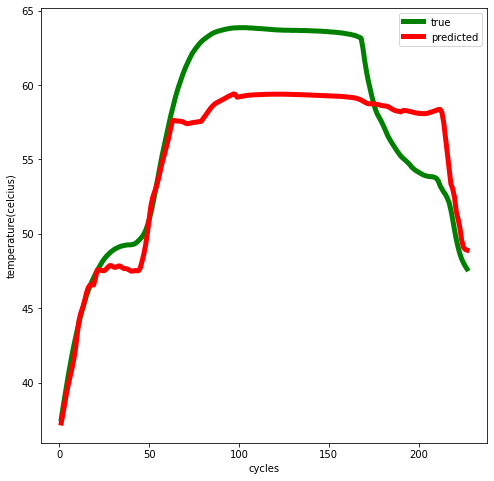

41


<Figure size 432x288 with 0 Axes>

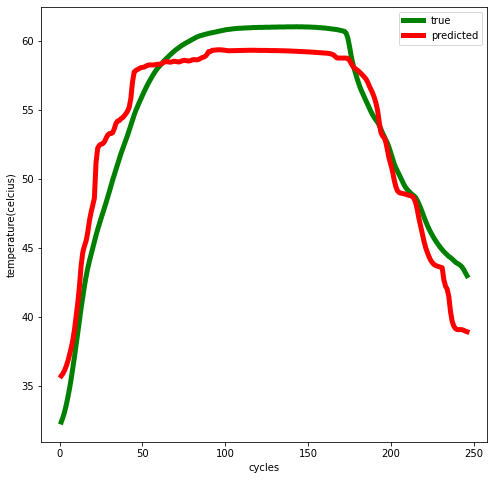

42


<Figure size 432x288 with 0 Axes>

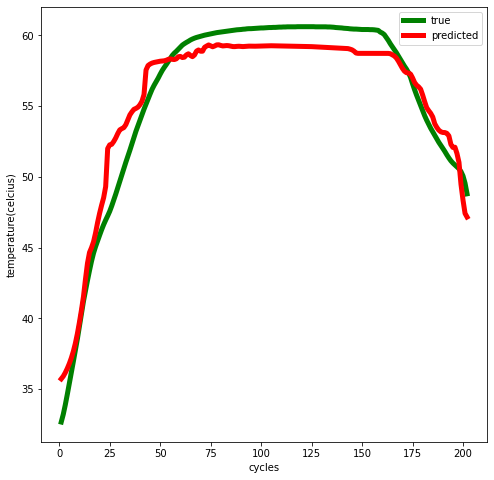

43


<Figure size 432x288 with 0 Axes>

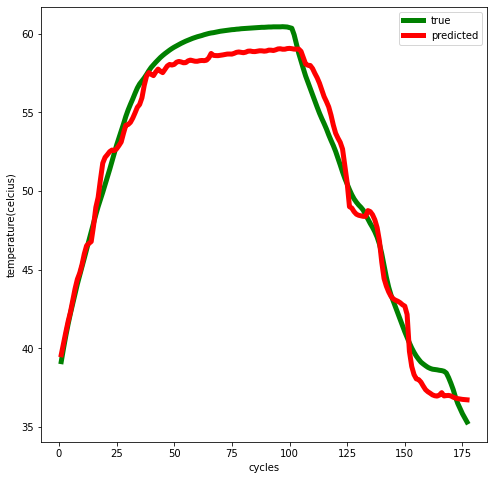

44


<Figure size 432x288 with 0 Axes>

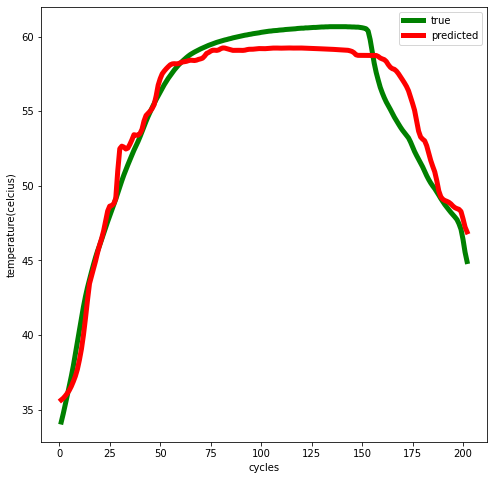

45


<Figure size 432x288 with 0 Axes>

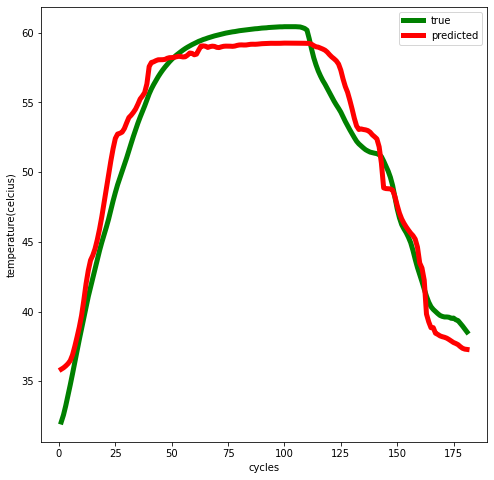

46


<Figure size 432x288 with 0 Axes>

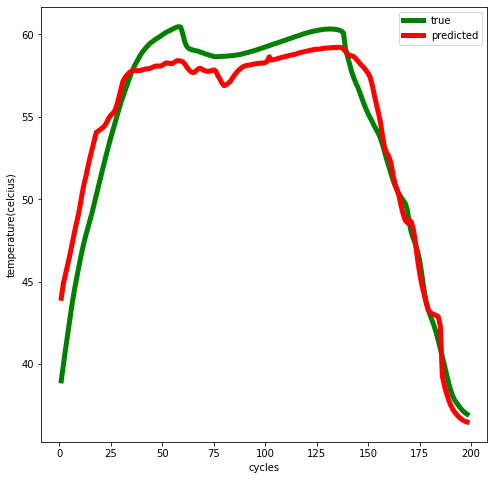

47


<Figure size 432x288 with 0 Axes>

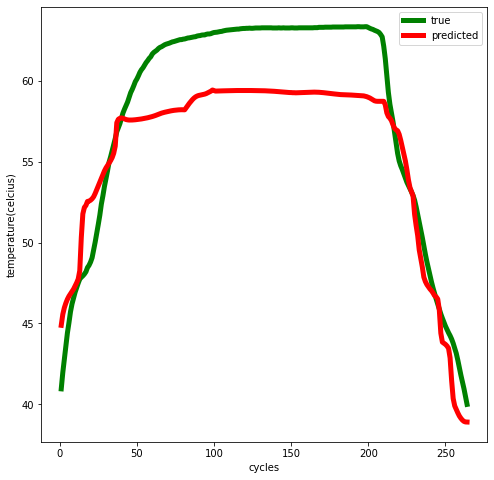

48


<Figure size 432x288 with 0 Axes>

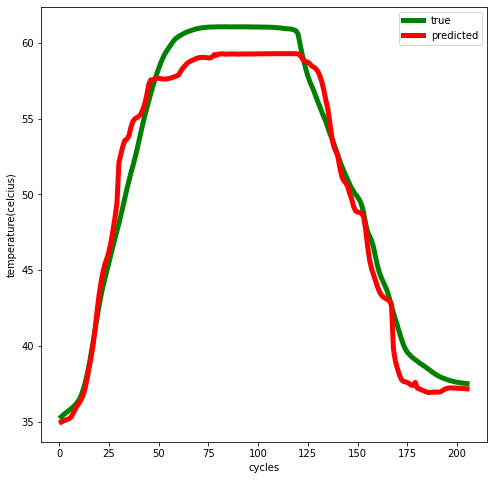

49


<Figure size 432x288 with 0 Axes>

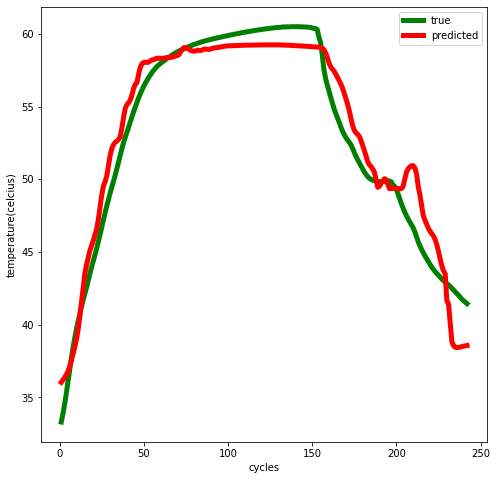

50


<Figure size 432x288 with 0 Axes>

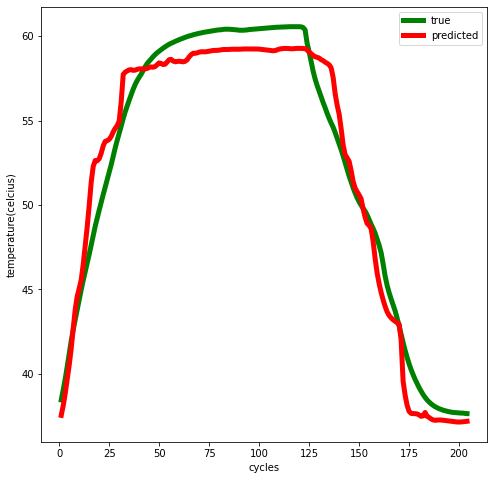

51


<Figure size 432x288 with 0 Axes>

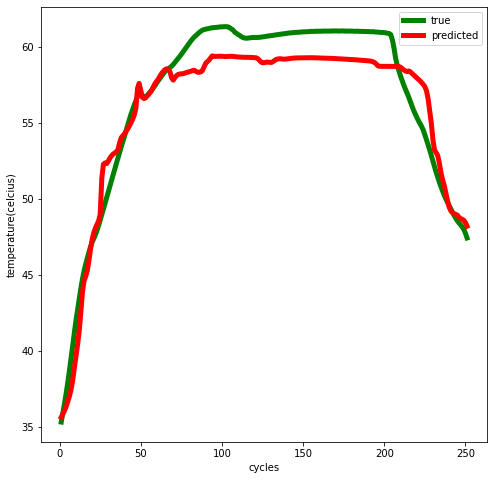

52


<Figure size 432x288 with 0 Axes>

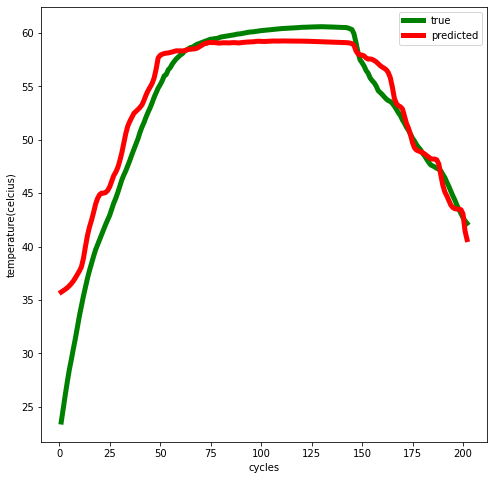

In [ ]:
# plot all predictions
for i in range(len(y_test_list)):
  print(i)
  my_plot(y_test_list[i],pred_list[i])